In [1]:
import os
import shutil
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d
from numpy import deg2rad
from scipy.ndimage import gaussian_filter1d
import sys
sys.path.append('/home/zilong/Desktop/GridCellThetaSweeps/CircularLinearReg')
from core import cl_corr


In [2]:
def load_data(ratname, file_path):
    # Load the .mat file
    with h5py.File(file_path, 'r') as f:
        # List all keys
        keys = list(f.keys())
        #print(f"Keys: {keys}")

        # Access the sdata structure
        sdata = f['sdata']

        # Check if 'light1' exists in sdata
        if 'light1' not in sdata:
            print(f"'light1' not found in {file_path}")
            return None

        # Accessing the light1 group and its datasets
        light1 = sdata['light1']
        ppox = np.array(light1['pox'])
        ppoy = np.array(light1['poy'])
        pot = np.array(light1['pot'])
        poh = np.array(light1['poh'])
        pov = np.array(light1['pov'])

        # Extract all cells containing the name 'R222'
        cell_names = [key for key in sdata.keys() if ratname in key]
        #print(f"Cell Names: {cell_names}")

        # Initialize dictionary to store data for all cells
        cells_data = {}

        # Iterate over each cell name and extract data
        for cell_name in cell_names:
            part_now = 'light1'  # Assuming 'light1' is the part_now equivalent

            pspx = np.array(sdata[cell_name][part_now]['spx'])
            pspy = np.array(sdata[cell_name][part_now]['spy'])
            pspt = np.array(sdata[cell_name][part_now]['spt'])
            pspv = np.array(sdata[cell_name][part_now]['spv'])
            psph = np.array(sdata[cell_name][part_now]['sph'])
            pspm = np.array(sdata[cell_name][part_now]['spm'])
            pval = np.array(sdata[cell_name][part_now]['pval'])
            spike_phase = np.array(sdata[cell_name][part_now]['spike_phase'])
            autocorrelogram = np.array(sdata[cell_name][part_now]['theta_train_long2'])
            hd_mean = np.array(sdata[cell_name][part_now]['hd_mean'])
            hd_std = np.array(sdata[cell_name][part_now]['hd_stdev'])
            tune_width = np.array(sdata[cell_name][part_now]['tuning_width'])

            # Extract and decode cell_type
            cell_type_array = np.array(sdata[cell_name][part_now]['thetacell_type'])
            cell_type = ''.join([chr(ascii_val[0]) for ascii_val in cell_type_array])

            # Store the data for this cell
            cells_data[cell_name] = {
                'pspx': pspx,
                'pspy': pspy,
                'pspt': pspt,
                'pspv': pspv,
                'psph': psph,
                'pspm': pspm,
                'pval': pval,
                'spike_phase': spike_phase,
                'autocorrelogram': autocorrelogram,
                'hd_mean': hd_mean,
                'hd_std': hd_std,
                'tune_width': tune_width,
                'cell_type': cell_type
            }

        # Create a dictionary to store all the data
        data_dict = {
            'ppox': ppox,
            'ppoy': ppoy,
            'pot': pot,
            'poh': poh,
            'pov': pov,
            'cell_names': cell_names,
            'cells_data': cells_data
        }

        return data_dict



In [3]:
def calculate_angular_speed(poh, pot, sigma=5):
    """
    Calculate the head rotation speed (angular speed) from head direction and time data.

    Parameters:
    poh : np.array
        Array of head direction angles in degrees.
    pot : np.array
        Array of time points corresponding to the head direction angles.
    sigma : float
        Standard deviation for Gaussian kernel used in smoothing.

    Returns:
    angular_speed : np.array
        Array of angular speed values.
    """

    # Ensure head direction angles are in radians
    poh_rad = np.deg2rad(poh)

    # Convert angles to complex exponential form
    poh_complex = np.exp(1j * poh_rad)

    # Apply Gaussian smoothing to real and imaginary parts separately
    poh_smooth_real = gaussian_filter1d(poh_complex.real, sigma=sigma)
    poh_smooth_imag = gaussian_filter1d(poh_complex.imag, sigma=sigma)

    # Convert back to angles
    poh_smooth = np.angle(poh_smooth_real + 1j * poh_smooth_imag)

    # Calculate the time differences
    dt = np.diff(pot)

    # Calculate the angle differences
    dtheta = np.diff(poh_smooth)
    
    #deal with the jump between 0 and 2pi
    dtheta[dtheta > np.pi] -= 2 * np.pi
    dtheta[dtheta < -np.pi] += 2 * np.pi
    
    # Calculate the angular speed
    angular_speed = dtheta / dt
    
    angular_speed = angular_speed.flatten()

    #add one element to the beginning of angular_speed to make it the same length as poh
    angular_speed = np.insert(angular_speed, 0, angular_speed[0])

    return angular_speed

def get_angular_speed_at_spikes(pspt, pot, angular_speed):

    angular_speed_spike = []
    for spike_time in pspt:
        # Find the index of the closest time in pot
        index = np.argmin(np.abs(pot - spike_time))
        angular_speed_spike.append(angular_speed[index])
    
    return np.array(angular_speed_spike)

def find_continuous_periods(angular_speed, pot, speed_threshold=0.5, duration_threshold=1.0):

    above_threshold = np.abs(angular_speed) < speed_threshold
    # Find the indices where the state changes
    change_indices = np.diff(above_threshold.astype(int), prepend=0, append=0)

    # Identify the start and end indices of the segments
    start_indices = np.where(change_indices == 1)[0]
    end_indices = np.where(change_indices == -1)[0]

    # Ensure there is a matching number of start and end indices
    if len(start_indices) > len(end_indices):
        end_indices = np.append(end_indices, len(angular_speed) - 1)
    elif len(end_indices) > len(start_indices):
        start_indices = np.insert(start_indices, 0, 0)

    continuous_periods = []
    for start, end in zip(start_indices, end_indices):
        if end >= len(pot):
            end = len(pot) - 1
        duration = pot[end] - pot[start]
        if duration >= duration_threshold:
            continuous_periods.append((pot[start], pot[end]))

    return continuous_periods

In [8]:
def plot_head_direction_tuning(ax, ppoh, psph, pval, hd_mean, hd_std, tune_width, cell_name, config, pos_tb=0.02):
    """
    Plot the head direction tuning map in a polar plot.

    Parameters:
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        The polar axes to plot on.
    ppoh : np.array
        Array of session head direction angles in degrees.
    psph : np.array
        Array of cell head direction angles in degrees.
    pos_tb : float
        Time base for converting session HD to time.
    cell_name : str
        Name of the cell for which the tuning map is plotted.
    config : dict
        Configuration dictionary containing 'hd_bins' and 'hd_boxcar' parameters.
    """

    # Convert angles to radians
    ppoh_rad = deg2rad(ppoh)
    psph_rad = deg2rad(psph)

    # Calculate histograms for session and cell head directions
    hd1, _ = np.histogram(ppoh_rad, bins=config['hd_bins'], range=(0, 2 * np.pi))
    hd2, _ = np.histogram(psph_rad, bins=config['hd_bins'], range=(0, 2 * np.pi))

    # Boxcar filter
    boxcar_size = config['hd_boxcar']
    boxcar_filter = np.ones(boxcar_size) / boxcar_size

    # Apply boxcar filter
    hd1_filtered = convolve1d(hd1, boxcar_filter, mode='wrap')
    hd2_filtered = convolve1d(hd2, boxcar_filter, mode='wrap')

    # Convert session HD to time (i.e., dwelling time in each HD bin)
    hd1_time = hd1_filtered * pos_tb

    # Calculate HD firing rate
    hd3 = hd2_filtered / hd1_time

    # Normalize session HD
    hd1_normalized = hd1_time / np.max(hd1_time)

    # Normalize cell HD firing rate
    hd3_normalized = hd3 / np.max(hd3)
    hd3_normalized = hd3_normalized.flatten()

    # Close the loop by appending the first element to the end
    theta = np.linspace(0, 2 * np.pi, config['hd_bins'], endpoint=False)
    theta = np.append(theta, theta[0])
    hd1_normalized = np.append(hd1_normalized, hd1_normalized[0])
    hd3_normalized = np.append(hd3_normalized, hd3_normalized[0])

    # Plot the session head direction with shading
    ax.plot(theta, hd1_normalized, label='Session Head Direction', color='gray')
    ax.fill_between(theta, 0, hd1_normalized, facecolor='gray', alpha=0.2)

    # Plot the cell head direction firing rate
    ax.plot(theta, hd3_normalized, label='Cell Head Direction Firing Rate', color='#38c7ff')
    ax.fill_between(theta, 0, hd3_normalized, facecolor='#38c7ff', alpha=0.5)

    #ax.set_title(cell_name + '\n'+str(np.round(hd_mean,1))+'('+str(np.round(hd_std,1))+')' +'\nRayleigh_p=' + str(np.round(pval, 4)), fontsize=10)
    
    ax.set_title(f"{cell_name}\nAngle:{hd_mean:.0f} ({hd_std:.0f})\nTuning width:{tune_width:.0f}\nRayleigh_p={pval:.4f}", fontsize=10)
    # ax.legend()

    return ax

def plot_autocorrelogram(ax, autocorrelogram, cell_type):
    
    ax.plot(autocorrelogram[1,:], autocorrelogram[0,:], 'k')
    #fillin between y=0 and autocorrelogram
    ax.fill_between(autocorrelogram[1,:], 0, autocorrelogram[0,:], facecolor='black')
    ax.set_xticks([-500, 0, 500])
    ax.set_yticks([])
    ax.set_xlabel('Lag (ms)')
    ax.set_title(cell_type)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    return ax

def plot_phaseprecession_v2(ax1, ppoh, pot, pspt, psph, hd_mean, spike_phase, config):
    
    spike_phase = spike_phase + np.pi #[-pi, pi] -> [0, 2pi]
    
    alpha = 0.5
    speed_threshold = config['speed_threshold']
    duration_threshold = config['duration_threshold']
    speed_smooth_sigma = config['speed_smooth_sigma']
    
    #calculate angular speed
    angular_speed = calculate_angular_speed(ppoh, pot, sigma=speed_smooth_sigma)
    
    #convert psph to radian
    psph = deg2rad(psph)
    hd_mean = deg2rad(hd_mean)
    
    psph_centered = np.mod(psph - hd_mean + np.pi, 2 * np.pi)
    
    #CCW plot in ax1
    continuous_periods_still = find_continuous_periods(angular_speed, pot, speed_threshold=speed_threshold, duration_threshold=duration_threshold)
    indx = []
    for i in range(len(continuous_periods_still)):
        indx.extend(np.where((pspt > continuous_periods_still[i][0]) & (pspt < continuous_periods_still[i][1]))[0])
        
    psph_still = psph_centered[indx]
    spike_phase_still = spike_phase[indx]
    
    ax1.scatter(psph_still, spike_phase_still, s=5, color='black', alpha=alpha)
    ax1.scatter(psph_still, [spike_phase_still[i] + 2 * np.pi for i in range(len(spike_phase_still))], s=5, color='black', alpha=alpha)
    
    circ_lin_corr, pval, slope, phi0, RR = cl_corr(psph_still, spike_phase_still, min_slope=0, max_slope=1/2/np.pi, bootstrap_iter=1000, return_pval=True)
    # Plot the circular-linear regression
    x = np.linspace(0, 2 * np.pi, 100)
    y = 2 * np.pi * slope * x + phi0
    ax1.plot(x, y, color='red', linewidth=2)    
    #add intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
    ax1.plot(x, y, color='red', linewidth=2)
    #add intercepr of 4*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
    ax1.plot(x, y, color='red', linewidth=2)
    #substrac intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
    ax1.plot(x, y, color='red', linewidth=2)
    
    
    
    # Print circ_lin_corr and p value
    ax1.set_title(f"Clr: {circ_lin_corr:.2f}\np-value: {pval:.3f}")
    # Add arrows and text for CCW
    ax1.annotate('', xy=(0.25, 1.2), xycoords='axes fraction', xytext=(0.75, 1.2), textcoords='axes fraction',
                arrowprops=dict(arrowstyle="->", lw=1.5, color='black'))
    ax1.text(0.5, 1.25, 'CCW', transform=ax1.transAxes, fontsize=10, ha='center')
      
    ax1.set_xlabel('Preferred direction')
    ax1.set_ylabel('Spike Phase')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    ax1.set_xlim(0, 2*np.pi)
    ax1.set_xticks([0, np.pi, 2*np.pi])
    ax1.set_xticklabels(["$-\pi$", "$0$", "$\pi$"])    
    
    ax1.set_ylim(0, 4*np.pi)
    ax1.set_yticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi])
    ax1.set_yticklabels(["$0$", "$\pi$", "$2\pi$", "$3\pi$", "$4\pi$"])    
    
    return ax1, pval

## save of directional tuning map from all head direction cells

In [9]:
base_dir = '/home/zilong/Desktop/GridCellThetaSweeps/LomiData/'
output_dir = '/home/zilong/Desktop/GridCellThetaSweeps/figures/HDTuning_still/'
output_skip_dir = '/home/zilong/Desktop/GridCellThetaSweeps/figures/HDTuning_skip_still/'
output_nonskip_dir = '/home/zilong/Desktop/GridCellThetaSweeps/figures/HDTuning_nonskip_still/'

# # Configuration
# config = {
#     'hd_bins': 60,
#     'hd_boxcar': 3,
#     'speed_threshold': 0.5,
#     'duration_threshold': 1.0,
#     'speed_smooth_sigma': 5, 
# }


config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
    'speed_threshold': 0.5,
    'duration_threshold': 1.0,
    'speed_smooth_sigma': 5, 
}

# Create output directory if it doesn't exist
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)    
os.makedirs(output_dir)

# Create output directory if it doesn't exist
if os.path.exists(output_skip_dir):
    shutil.rmtree(output_skip_dir)    
os.makedirs(output_skip_dir)

# Create output directory if it doesn't exist
if os.path.exists(output_nonskip_dir):
    shutil.rmtree(output_nonskip_dir)    
os.makedirs(output_nonskip_dir)

total_hd_cells = 0

psph_CW_all = []
spike_phase_CW_all = [] 
psph_CCW_all = [] 
spike_phase_CCW_all = []
pval_skip = []
pval_nonskip = []

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = load_data(ratname, file_path)
                
                if data_dict is not None:
                    ppoh = data_dict['poh']
                    pot = data_dict['pot'].flatten()
                    for cell_name, cell_data in data_dict['cells_data'].items():
                        psph = cell_data['psph'].flatten()
                        pspt = cell_data['pspt'].flatten()
                        spike_phase = cell_data['spike_phase'].flatten()
                        pval = cell_data['pval'][0][0]
                        hd_mean = cell_data['hd_mean'][0][0]
                        hd_std = cell_data['hd_std'][0][0]
                        tune_width = cell_data['tune_width'][0][0]
                        autocorrelogram = cell_data['autocorrelogram']
                        cell_type = cell_data['cell_type']
                        
                        if pval < 0.05: #select only head direction tuned cells
                            
                            fig = plt.figure(figsize=(12, 4))
                            gs=fig.add_gridspec(1, 3)
                            
                            #plot head direction tuning map
                            ax0 = fig.add_subplot(gs[0, 0], projection='polar')
                            ax0 = plot_head_direction_tuning(ax0, ppoh, psph, pval, hd_mean, hd_std, tune_width, cell_name, config)
                            
                            #plot autocorrelogram, i.e., check theta modulation
                            ax1 = fig.add_subplot(gs[0, 1])
                            autocorrelogram = cell_data['autocorrelogram']
                            ax1 = plot_autocorrelogram(ax1, autocorrelogram, cell_type)
                            
                            #plot spike phase versus head direction, i.e., check phase precession
                            ax2 = fig.add_subplot(gs[0, 2])
                            ax2,combined_pval = plot_phaseprecession_v2(ax2, ppoh, pot, pspt, psph, hd_mean, spike_phase,config)
                            
                            output_path = os.path.join(output_dir, f"{cell_name}.png")
                            plt.tight_layout()
                            plt.savefig(output_path)
                            
                            #save fig according to cell type in different folders
                            if 'ThetaxHD' in cell_type:
                            
                                if 'skip'in cell_type:
                                    pval_skip.append(combined_pval)
                                    output_skip_path = os.path.join(output_skip_dir, f"{cell_name}.png")
                                    plt.savefig(output_skip_path)
                                elif 'Strong ThetaxHD' in cell_type:
                                    pval_nonskip.append(combined_pval)
                                    output_nonskip_path = os.path.join(output_nonskip_dir, f"{cell_name}.png")
                                    plt.savefig(output_nonskip_path)
                                
                                
                            plt.close(fig)
                            
                            total_hd_cells += 1
                    
print(f"Total number of HD cells processed: {total_hd_cells}")


Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_170719_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_100919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_250719_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_090819_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_030919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_030919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_230819_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_200819_T1_sdata.mat
Processing /home/z

In [10]:
# ratio of pval_skip<0.05
pval_skip = np.array(pval_skip)
pval_nonskip = np.array(pval_nonskip)
print('ratio of pval_skip<0.05:', len(pval_skip[pval_skip<0.05])/len(pval_skip))
print('ratio of pval_nonskip<0.05:', len(pval_nonskip[pval_nonskip<0.05])/len(pval_nonskip))

ratio of pval_skip<0.05: 0.06666666666666667
ratio of pval_nonskip<0.05: 0.06818181818181818


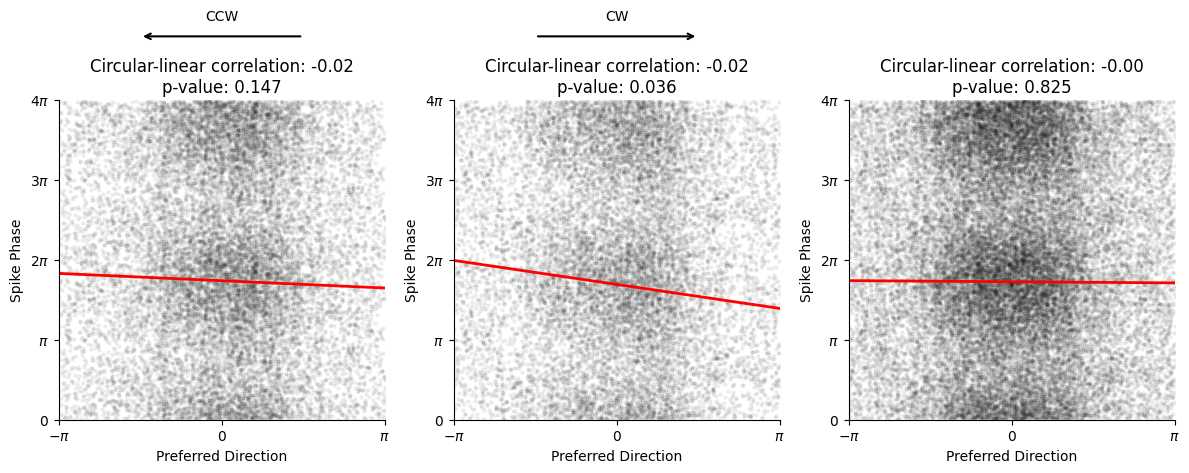

In [ ]:
# Assuming psph_CW_all, spike_phase_CW_all, psph_CCW_all, spike_phase_CCW_all are lists of arrays
psph_CW_all_combined = np.concatenate(psph_CW_all)
spike_phase_CW_all_combined = np.concatenate(spike_phase_CW_all)
psph_CCW_all_combined = np.concatenate(psph_CCW_all)
spike_phase_CCW_all_combined = np.concatenate(spike_phase_CCW_all)

# Flip the CCW values
psph_CCW_all_flipped = 2 * np.pi - psph_CCW_all_combined

# Combine CW and flipped CCW data
psph_combined = np.concatenate([psph_CW_all_combined, psph_CCW_all_flipped])
spike_phase_combined = np.concatenate([spike_phase_CW_all_combined, spike_phase_CCW_all_combined])

fig, axs = plt.subplots(1, 3, figsize=(12, 5))
alpha = 0.05

# Plot CCW data
ax = axs[0]
ax.scatter(psph_CCW_all_combined, spike_phase_CCW_all_combined, s=5, color='black', alpha=alpha)
ax.scatter(psph_CCW_all_combined, spike_phase_CCW_all_combined + 2 * np.pi, s=5, color='black', alpha=alpha)

circ_lin_corr, pval, slope, phi0, RR = cl_corr(psph_CCW_all_combined, spike_phase_CCW_all_combined, min_slope=-1, max_slope=1, bootstrap_iter=1000, return_pval=True)
# Plot the circular-linear regression
x = np.linspace(0, 2 * np.pi, 100)
y = 2 * np.pi * slope * x + phi0
ax.plot(x, y, color='red', linewidth=2)

# Print circ_lin_corr and p value
ax.set_title(f"Circular-linear correlation: {circ_lin_corr:.2f}\np-value: {pval:.3f}")
# Add arrows and text for CCW
ax.annotate('', xy=(0.25, 1.2), xycoords='axes fraction', xytext=(0.75, 1.2), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->", lw=1.5, color='black'))
ax.text(0.5, 1.25, 'CCW', transform=ax.transAxes, fontsize=10, ha='center')

ax.set_xlabel('Preferred Direction')
ax.set_ylabel('Spike Phase')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim(0, 2 * np.pi)
ax.set_xticks([0, np.pi, 2 * np.pi])
ax.set_xticklabels(["$-\pi$", "$0$", "$\pi$"])    

ax.set_ylim(0, 4 * np.pi)
ax.set_yticks([0, np.pi, 2 * np.pi, 3 * np.pi, 4*np.pi])
ax.set_yticklabels(["$0$", "$\pi$", "$2\pi$", "$3\pi$", "$4\pi$"])

# Plot CW data
ax = axs[1]
ax.scatter(psph_CW_all_combined, spike_phase_CW_all_combined, s=5, color='black', alpha=alpha)
ax.scatter(psph_CW_all_combined, spike_phase_CW_all_combined + 2 * np.pi, s=5, color='black', alpha=alpha)

circ_lin_corr, pval, slope, phi0, RR = cl_corr(psph_CW_all_combined, spike_phase_CW_all_combined, min_slope=-1, max_slope=1, bootstrap_iter=1000, return_pval=True)
# Plot the circular-linear regression
x = np.linspace(0, 2 * np.pi, 100)
y = 2 * np.pi * slope * x + phi0
ax.plot(x, y, color='red', linewidth=2)

# Print circ_lin_corr and p value
ax.set_title(f"Circular-linear correlation: {circ_lin_corr:.2f}\np-value: {pval:.3f}")
# Add arrows and text for CW
ax.annotate('', xy=(0.75, 1.2), xycoords='axes fraction', xytext=(0.25, 1.2), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->", lw=1.5, color='black'))
ax.text(0.5, 1.25, 'CW', transform=ax.transAxes, fontsize=10, ha='center')

ax.set_xlabel('Preferred Direction')
ax.set_ylabel('Spike Phase')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim(0, 2 * np.pi)
ax.set_xticks([0, np.pi, 2 * np.pi])
ax.set_xticklabels(["$-\pi$", "$0$", "$\pi$"])    

ax.set_ylim(0, 4 * np.pi)
ax.set_yticks([0, np.pi, 2 * np.pi, 3 * np.pi, 4*np.pi])
ax.set_yticklabels(["$0$", "$\pi$", "$2\pi$", "$3\pi$", "$4\pi$"])

# Plot combined data
ax = axs[2]
ax.scatter(psph_combined, spike_phase_combined, s=5, color='black', alpha=alpha)
ax.scatter(psph_combined, spike_phase_combined + 2 * np.pi, s=5, color='black', alpha=alpha)

circ_lin_corr, pval, slope, phi0, RR = cl_corr(psph_combined, spike_phase_combined, min_slope=-1, max_slope=1, bootstrap_iter=1000, return_pval=True)
# Plot the circular-linear regression
x = np.linspace(0, 2 * np.pi, 100)
y = 2 * np.pi * slope * x + phi0
ax.plot(x, y, color='red', linewidth=2)

# Print circ_lin_corr and p value
ax.set_title(f"Circular-linear correlation: {circ_lin_corr:.2f}\np-value: {pval:.3f}")

ax.set_xlabel('Preferred Direction')
ax.set_ylabel('Spike Phase')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim(0, 2 * np.pi)
ax.set_xticks([0, np.pi, 2 * np.pi])
ax.set_xticklabels(["$-\pi$", "$0$", "$\pi$"])    

ax.set_ylim(0, 4 * np.pi)
ax.set_yticks([0, np.pi, 2 * np.pi, 3 * np.pi, 4*np.pi])
ax.set_yticklabels(["$0$", "$\pi$", "$2\pi$", "$3\pi$", "$4\pi$"])

plt.tight_layout()
plt.show()


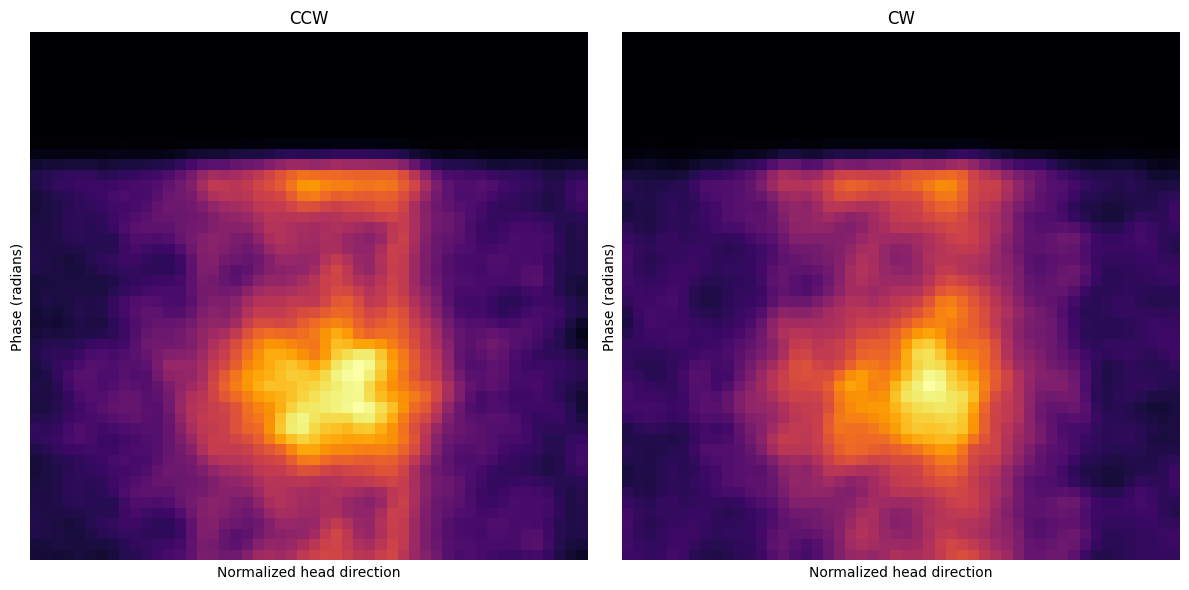

In [ ]:
import seaborn as sns
from scipy.ndimage import gaussian_filter

# Normalize position (assuming position is equivalent to psph for this example, adapt as needed)
normalized_position_CW = (psph_CW_all_combined - psph_CW_all_combined.min()) / (psph_CW_all_combined.max() - psph_CW_all_combined.min())
normalized_position_CCW = (psph_CCW_all_combined - psph_CCW_all_combined.min()) / (psph_CCW_all_combined.max() - psph_CCW_all_combined.min())

# Repeat the phase values by adding 2*pi
spike_phase_CW_all_combined_repeated = np.concatenate([spike_phase_CW_all_combined, spike_phase_CW_all_combined + 2 * np.pi])
spike_phase_CCW_all_combined_repeated = np.concatenate([spike_phase_CCW_all_combined, spike_phase_CCW_all_combined + 2 * np.pi])

# Repeat the normalized positions to match the repeated phase values
normalized_position_CW_repeated = np.tile(normalized_position_CW, 2)
normalized_position_CCW_repeated = np.tile(normalized_position_CCW, 2)

# Create heatmap data using 2D histogram
heatmap_data_CW, xedges_CW, yedges_CW = np.histogram2d(normalized_position_CW_repeated, spike_phase_CW_all_combined_repeated, bins=(50, 50), range=[[0, 1], [-np.pi, 3 * np.pi]])
heatmap_data_CCW, xedges_CCW, yedges_CCW = np.histogram2d(normalized_position_CCW_repeated, spike_phase_CCW_all_combined_repeated, bins=(50, 50), range=[[0, 1], [-np.pi, 3 * np.pi]])

# Normalize the heatmap data
heatmap_data_CW = heatmap_data_CW.T / heatmap_data_CW.max()
heatmap_data_CCW = heatmap_data_CCW.T / heatmap_data_CCW.max()

# Apply Gaussian smoothing
sigma = 1  # Adjust sigma for more or less smoothing
heatmap_data_CW_smooth = gaussian_filter(heatmap_data_CW, sigma=sigma)
heatmap_data_CCW_smooth = gaussian_filter(heatmap_data_CCW, sigma=sigma)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Forward travel (CW)
sns.heatmap(heatmap_data_CCW_smooth, ax=axs[0], xticklabels=np.round(np.linspace(0, 1, 5), 2), yticklabels=np.round(np.linspace(0, 4 * np.pi, 5), 2), cbar=False, cmap='inferno')
axs[0].set_title('CCW')
axs[0].set_xlabel('Normalized head direction')
axs[0].set_ylabel('Phase (radians)')


# Backward travel (CCW)
sns.heatmap(heatmap_data_CW_smooth, ax=axs[1], xticklabels=np.round(np.linspace(0, 1, 5), 2), yticklabels=np.round(np.linspace(0, 4 * np.pi, 5), 2), cbar=False, cmap='inferno')
axs[1].set_title('CW')
axs[1].set_xlabel('Normalized head direction')
axs[1].set_ylabel('Phase (radians)')


#remove x and y ticks
axs[0].set_yticks([])
axs[1].set_yticks([])
axs[0].set_xticks([])
axs[1].set_xticks([])


plt.tight_layout()
plt.show()